In [1]:
import pandas as pd
import numpy as np
from pulp import *
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from math import sqrt

from keras.models import Sequential
from keras.layers import LSTM, Dropout
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras import backend as K

Using TensorFlow backend.


In [2]:
# array stacking
def create_sequence(df, cols, time_indexes, target):
  seqs = []
  for col in cols:
    seq = df[col].values.reshape((len(df[col]), 1))
    seqs.append(seq)
  for index in time_indexes:
    seq = index.values.reshape((len(df[col]), 1))
    seqs.append(seq)
  seq = df[target].values.reshape((len(df[target]), 1))
  for i in range(len(seq)):
    if seq[i] < 0:
      seq[i] = 0
  seqs.append(seq)
  dataset = np.hstack((seqs))  
  return dataset

def split_sequence_multi(sequence, n_steps, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    out_ix = end_ix + n_steps_out
    # boundary check
    if out_ix > len(sequence):
      break
    seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix:out_ix, -1]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

# https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
def sMAPE(y_true, y_pred):
    #Symmetric mean absolute percentage error
    return 100 * K.mean(K.abs(y_pred - y_true) / (K.abs(y_pred) + K.abs(y_true)), axis=-1)

## Solar power forecasting

In [7]:
df = pd.read_csv('../LSTM-power-forecasting/pvdaq_2012_2014_hourly.csv', header=0, infer_datetime_format=True, parse_dates=['Date-Time'], index_col=['Date-Time'])

In [11]:
# columns to use for forecasting
cols = ['ambient_temp', 'inverter_temp', 'module_temp', 'poa_irradiance', 
        'relative_humidity', 'wind_direction', 'wind_speed']
time_indexes = [df.index.hour, df.index.month]
# we will forecast dc power output
target = ['dc_power']

In [12]:
dataset = (create_sequence(df, cols, time_indexes, target))
X, y = split_sequence_multi(dataset, 12, 6)
print(X.shape, y.shape)

(26287, 12, 10) (26287, 6)


In [7]:
# n_steps is amount of time steps per sample
# n_steps_out is the amount of time steps model has to forecast
n_steps, n_steps_out = 24, 6
# number of features in each timestep
n_features=X.shape[2]
X, y = split_sequence_multi(dataset, n_steps, n_steps_out)
train_X, train_y = X[:-2000,:], y[:-2000,:]
val_X, val_y = X[-2000:-1000,:], y[-2000:-1000,:]
test_X, test_y = X[-1000:,:], y[-1000:,:]

model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(200, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae')

model.fit(train_X, train_y, batch_size=32, epochs = 20, validation_data=(val_X, val_y))
# A stateful recurrent model is one for which the internal states (memories) 
# obtained after processing a batch of samples are reused as initial states for the samples of the next batch

predictions = model.predict(test_X)

predictions1 = model.predict(train_X)
mse = mean_squared_error(train_y, predictions1)
rmse = sqrt(mse)
mae = mean_absolute_error(train_y, predictions1)
#mape = mean_absolute_percentage_error(predictions1, test_y)
print('MSE:',round(mse),'RMSE:', round(rmse),'MAE:', round(mae))

test_seq1 = []
pred_seq1 = []
for i in range(36):
  test_seq1 = np.concatenate((test_seq1, test_y[i*6]))
  pred_seq1 = np.concatenate((pred_seq1, predictions[i*6]))

Train on 24275 samples, validate on 1000 samples
Epoch 1/20
24275/24275 [==============================] - 118s 5ms/step - loss: 6765.4497 - val_loss: 4153.4015
Epoch 2/20
24275/24275 [==============================] - 114s 5ms/step - loss: 4566.9811 - val_loss: 2652.3052
Epoch 3/20
24275/24275 [==============================] - 117s 5ms/step - loss: 4044.2069 - val_loss: 3089.7227
Epoch 4/20
24275/24275 [==============================] - 124s 5ms/step - loss: 3199.9827 - val_loss: 2539.5504
Epoch 5/20
24275/24275 [==============================] - 121s 5ms/step - loss: 3659.0919 - val_loss: 2192.9824
Epoch 6/20
24275/24275 [==============================] - 131s 5ms/step - loss: 4732.9381 - val_loss: 2490.4529
Epoch 7/20
24275/24275 [==============================] - 137s 6ms/step - loss: 2824.1887 - val_loss: 1578.1886
Epoch 8/20
24275/24275 [==============================] - 131s 5ms/step - loss: 2397.4566 - val_loss: 2574.0451
Epoch 9/20
24275/24275 [==============================]

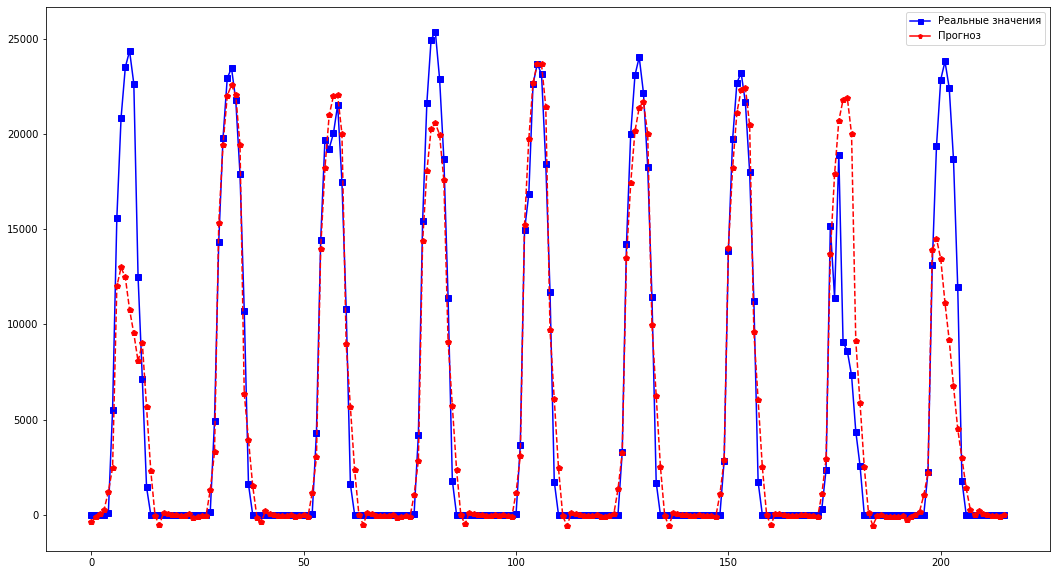

In [9]:
blue_line = mlines.Line2D([], [], color='blue', marker='s',
                          markersize=5, label='Реальные значения')
red_line = mlines.Line2D([], [], color='red', marker='p',
                          markersize=5, label='Прогноз')

#plt.legend(handles=[blue_line, red_line])


plt.figure(figsize=(18,10))
plt.plot(test_seq1, 'b-s')
plt.plot(pred_seq1, 'r--p')
plt.legend(handles=[blue_line, red_line])

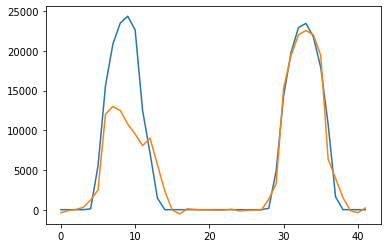

In [10]:
test_seq = np.concatenate((test_y[0], test_y[6], test_y[12], test_y[18], test_y[24], test_y[30], test_y[36]))
pred_seq = np.concatenate((predictions[0], predictions[6], predictions[12], predictions[18], predictions[24], predictions[30], predictions[36]))
plt.plot(test_seq)
plt.plot(pred_seq)

## Power consumption forecasting

In [12]:
house_df = pd.read_csv('datasets/KAG_energydata_complete.csv', header=0, infer_datetime_format=True, parse_dates=['date'], index_col=['date'])

In [13]:
house_df.head(20)

Appliances  lights         T1       RH_1         T2  \
date                                                                       
2016-01-11 17:00:00          60      30  19.890000  47.596667  19.200000   
2016-01-11 17:10:00          60      30  19.890000  46.693333  19.200000   
2016-01-11 17:20:00          50      30  19.890000  46.300000  19.200000   
2016-01-11 17:30:00          50      40  19.890000  46.066667  19.200000   
2016-01-11 17:40:00          60      40  19.890000  46.333333  19.200000   
2016-01-11 17:50:00          50      40  19.890000  46.026667  19.200000   
2016-01-11 18:00:00          60      50  19.890000  45.766667  19.200000   
2016-01-11 18:10:00          60      50  19.856667  45.560000  19.200000   
2016-01-11 18:20:00          60      40  19.790000  45.597500  19.200000   
2016-01-11 18:30:00          70      40  19.856667  46.090000  19.230000   
2016-01-11 18:40:00         230      70  19.926667  45.863333  19.356667   
2016-01-11 18:50:00         580      60  20.066667  46.396667  19.426667   
2016-01-11 19:00:00         430      50  20.133333  48.000000  19.566667   
2016-01-11 19:10:00         250      40  20.260000  52.726667  19.730000   
2016-01-11 19:20:00         100      10  20.426667  55.893333  19.856667   
2016-01-11 19:30:00         100      10  20.566667  53.893333  20.033333   
2016-01-11 19:40:00          90      10  20.730000  52.660000  20.166667   
2016-01-11 19:50:00          70      30  20.856667  53.660000  20.200000   
2016-01-11 20:00:00          80      30  20.890000  51.193333  20.200000   
2016-01-11 20:10:00         140      40  20.890000  49.800000  20.200000   

                          RH_2         T3       RH_3         T4       RH_4  \
date                                                                         
2016-01-11 17:00:00  44.790000  19.790000  44.730000  19.000000  45.566667   
2016-01-11 17:10:00  44.722500  19.790000  44.790000  19.000000  45.992500   
2016-01-11 17:20:00  44.626667  19.790000  44.933333  18.926667  45.890000   
2016-01-11 17:30:00  44.590000  19.790000  45.000000  18.890000  45.723333   
2016-01-11 17:40:00  44.530000  19.790000  45.000000  18.890000  45.530000   
2016-01-11 17:50:00  44.500000  19.790000  44.933333  18.890000  45.730000   
2016-01-11 18:00:00  44.500000  19.790000  44.900000  18.890000  45.790000   
2016-01-11 18:10:00  44.500000  19.730000  44.900000  18.890000  45.863333   
2016-01-11 18:20:00  44.433333  19.730000  44.790000  18.890000  45.790000   
2016-01-11 18:30:00  44.400000  19.790000  44.863333  18.890000  46.096667   
2016-01-11 18:40:00  44.400000  19.790000  44.900000  18.890000  46.430000   
2016-01-11 18:50:00  44.400000  19.790000  44.826667  19.000000  46.430000   
2016-01-11 19:00:00  44.400000  19.890000  44.900000  19.000000  46.363333   
2016-01-11 19:10:00  45.100000  19.890000  45.493333  19.000000  47.223333   
2016-01-11 19:20:00  45.833333  20.033333  47.526667  19.000000  48.696667   
2016-01-11 19:30:00  46.756667  20.100000  48.466667  19.000000  48.490000   
2016-01-11 19:40:00  47.223333  20.200000  48.530000  18.926667  48.156667   
2016-01-11 19:50:00  47.056667  20.200000  48.447500  18.890000  47.963333   
2016-01-11 20:00:00  46.330000  20.200000  48.193333  18.963333  48.630000   
2016-01-11 20:10:00  46.026667  20.166667  47.633333  19.033333  49.500000   

                     ...         T9       RH_9     T_out  Press_mm_hg  \
date                 ...                                                
2016-01-11 17:00:00  ...  17.033333  45.530000  6.600000   733.500000   
2016-01-11 17:10:00  ...  17.066667  45.560000  6.483333   733.600000   
2016-01-11 17:20:00  ...  17.000000  45.500000  6.366667   733.700000   
2016-01-11 17:30:00  ...  17.000000  45.400000  6.250000   733.800000   
2016-01-11 17:40:00  ...  17.000000  45.400000  6.133333   733.900000   
2016-01-11 17:50:00  ...  17.000000  45.290000  6.016667   734.000000   
2016-01-11 18:00:00  ...  17.000000  45.290000 

In [22]:
house_df['consumption'] = house_df['Appliances'] + house_df['lights']
# resampling dataframe to hourly format to match everything
#resampled_wind_df = wind_df.resample('1H').median().drop(['consumption', 'Appliances', 'lights'], axis=1)
#resampled_wind_df['consumption'] = wind_df.resample('1H').sum()['consumption']
#wind_df = resampled_wind_df

cols = ['T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9']
target = ['consumption']
time_indexes = [house_df.index.hour, house_df.index.dayofweek, house_df.index.month]
house_dataset = create_sequence(house_df, cols, time_indexes, target)

In [24]:
# n_steps is amount of time steps per sample
# n_steps_out is the amount of time steps model has to forecast
n_steps, n_steps_out = 24, 6
# number of features in each timestep
X, y = split_sequence_multi(house_dataset, n_steps, n_steps_out)
n_features=X.shape[2]
train_X, train_y = X[:14000,:], y[:14000,:]
val_X, val_y = X[14000:16000,:], y[14000:16000,:]
test_X, test_y = X[16000:,:], y[16000:,:]

#train_X, train_y = X[:2000,:], y[:2000,:]
#val_X, val_y = X[2000:2600,:], y[2000:2600,:]
#test_X, test_y = X[2600:,:], y[2600:,:]

print('train:', len(train_X), 'val:', len(val_X), 'test:', len(test_X))


model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(200, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae')

model.fit(train_X, train_y, batch_size=32, epochs = 14, validation_data=(val_X, val_y))
# A stateful recurrent model is one for which the internal states (memories) 
# obtained after processing a batch of samples are reused as initial states for the samples of the next batch

predictions = model.predict(test_X)

predictions1 = model.predict(train_X)
mse = mean_squared_error(train_y, predictions1)
rmse = sqrt(mse)
mae = mean_absolute_error(train_y, predictions1)
#mape = mean_absolute_percentage_error(predictions1, test_y)
print('MSE:',round(mse),'RMSE:', round(rmse),'MAE:', round(mae))



train: 14000 val: 2000 test: 3706
Train on 14000 samples, validate on 2000 samples
Epoch 1/14
14000/14000 [==============================] - 62s 4ms/step - loss: 336.1485 - val_loss: 405.1819
Epoch 2/14
14000/14000 [==============================] - 61s 4ms/step - loss: 148.7603 - val_loss: 53.3380
Epoch 3/14
14000/14000 [==============================] - 61s 4ms/step - loss: 59.3624 - val_loss: 48.0626
Epoch 4/14
14000/14000 [==============================] - 62s 4ms/step - loss: 55.5140 - val_loss: 46.7753
Epoch 5/14
14000/14000 [==============================] - 61s 4ms/step - loss: 53.7411 - val_loss: 43.3864
Epoch 6/14
14000/14000 [==============================] - 61s 4ms/step - loss: 51.2925 - val_loss: 41.2730
Epoch 7/14
14000/14000 [==============================] - 62s 4ms/step - loss: 50.1288 - val_loss: 42.7164
Epoch 8/14
14000/14000 [==============================] - 61s 4ms/step - loss: 49.1980 - val_loss: 41.2715
Epoch 9/14
14000/14000 [==============================] - 

In [26]:
house_test_seq1 = []
house_pred_seq1 = []
for i in range(216):
  house_test_seq1 = np.concatenate((house_test_seq1, test_y[i*6]))
  house_pred_seq1 = np.concatenate((house_pred_seq1, predictions[i*6]))

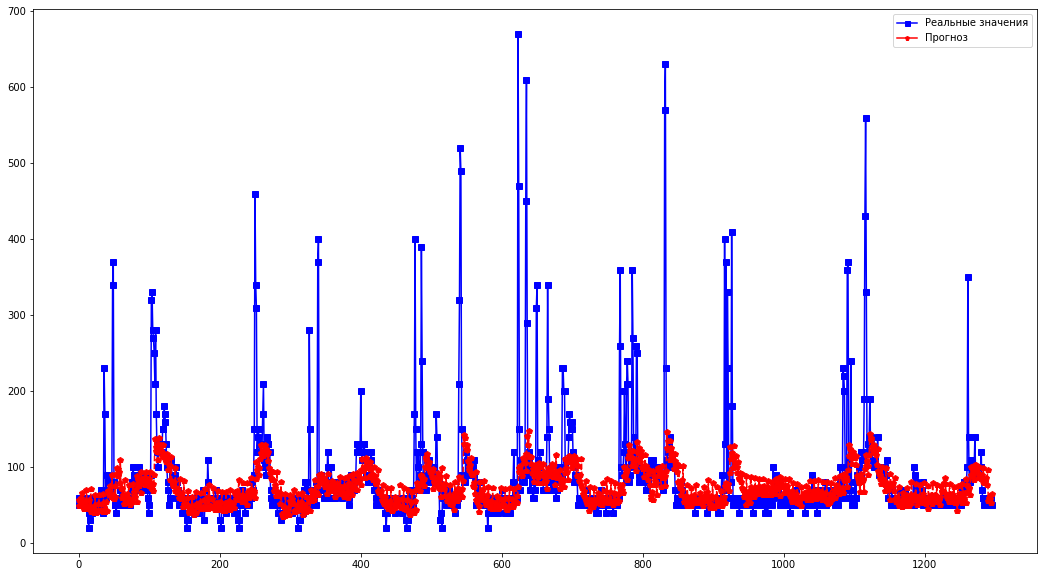

In [27]:
blue_line = mlines.Line2D([], [], color='blue', marker='s',
                          markersize=5, label='Реальные значения')
red_line = mlines.Line2D([], [], color='red', marker='p',
                          markersize=5, label='Прогноз')

#plt.legend(handles=[blue_line, red_line])


plt.figure(figsize=(18,10))
plt.plot(wind_test_seq1, 'b-s')
plt.plot(wind_pred_seq1, 'r--p')
plt.legend(handles=[blue_line, red_line])

## Energy consumption forecast

In [33]:
wind_df = pd.read_csv('datasets/T1.csv', header=0, infer_datetime_format=True, parse_dates=['Date/Time'], index_col=['Date/Time'])

In [34]:
wind_df

LV ActivePower (kW)  Wind Speed (m/s)  \
Date/Time                                                    
2018-01-01 00:00:00           380.047791          5.311336   
2018-01-01 00:10:00           453.769196          5.672167   
2018-01-01 00:20:00           306.376587          5.216037   
2018-01-01 00:30:00           419.645905          5.659674   
2018-01-01 00:40:00           380.650696          5.577941   
...                                  ...               ...   
2018-12-31 23:10:00          2963.980957         11.404030   
2018-12-31 23:20:00          1684.353027          7.332648   
2018-12-31 23:30:00          2201.106934          8.435358   
2018-12-31 23:40:00          2515.694092          9.421366   
2018-12-31 23:50:00          2820.466064          9.979332   

                     Theoretical_Power_Curve (KWh)  Wind Direction (°)  
Date/Time                                                               
2018-01-01 00:00:00                     416.328908          259.994904  
2018-01-01 00:10:00                     519.917511          268.641113  
2018-01-01 00:20:00                     390.900016          272.564789  
2018-01-01 00:30:00                     516.127569          271.258087  
2018-01-01 00:40:00                     491.702972          265.674286  
...                                            ...                 ...  
2018-12-31 23:10:00                    3397.190793           80.502724  
2018-12-31 23:20:00                    1173.055771           84.062599  
2018-12-31 23:30:00                    1788.284755           84.742500  
2018-12-31 23:40:00                    2418.382503           84.297913  
2018-12-31 23:50:00                    2779.184096           82.274620  

[50530 rows x 4 columns]

In [37]:
cols = ['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']
target = ['LV ActivePower (kW)']
time_indexes = [wind_df.index.hour, house_df.index.month]
wind_dataset = create_sequence(wind_df, cols, time_indexes, target)


In [ ]:
# n_steps is amount of time steps per sample
# n_steps_out is the amount of time steps model has to forecast
n_steps, n_steps_out = 24, 6
# number of features in each timestep
X, y = split_sequence_multi(house_dataset, n_steps, n_steps_out)
n_features=X.shape[2]
train_X, train_y = X[:30000,:], y[:30000,:]
val_X, val_y = X[30000:40000,:], y[30000:40000,:]
test_X, test_y = X[40000:,:], y[40000:,:]

#train_X, train_y = X[:2000,:], y[:2000,:]
#val_X, val_y = X[2000:2600,:], y[2000:2600,:]
#test_X, test_y = X[2600:,:], y[2600:,:]

print('train:', len(train_X), 'val:', len(val_X), 'test:', len(test_X))


model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(200, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae')

model.fit(train_X, train_y, batch_size=32, epochs = 14, validation_data=(val_X, val_y))
# A stateful recurrent model is one for which the internal states (memories) 
# obtained after processing a batch of samples are reused as initial states for the samples of the next batch

predictions = model.predict(test_X)

predictions1 = model.predict(train_X)
mse = mean_squared_error(train_y, predictions1)
rmse = sqrt(mse)
mae = mean_absolute_error(train_y, predictions1)
#mape = mean_absolute_percentage_error(predictions1, test_y)
print('MSE:',round(mse),'RMSE:', round(rmse),'MAE:', round(mae))



In [ ]:
for row in seq_list:
    # row contains maximum possible amount of energy output
    problem = LpProblem("power_optimization", LpMinimize)

    # Prices for energy
    solar_price = 1
    wind_price = 1
    grid_price = 3

    # Energy demand
    demand = 1000

    # Variables
    solar_power = LpVariable('solar_power', 0, row[0])
    wind_power = LpVariable('wind_power', 0, row[1])
    grid_power = LpVariable('grid_power', 0, 10000)

    # Constraints
    c1 = solar_power + wind_power + grid_power >= demand

    # Objective
    objective = solar_power*solar_price + wind_power*wind_price + grid_power*grid_price

    # Adding constraints and objectives to problem
    problem += c1
    problem += objective

    #Solving
    print(problem)
    problem.solve()

    # Print solution
    for i in [solar_power, wind_power, grid_power, objective]:
        print(i,"=" ,value(i))